# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

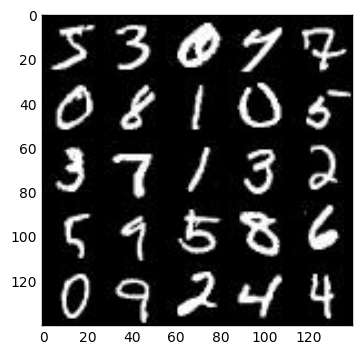

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

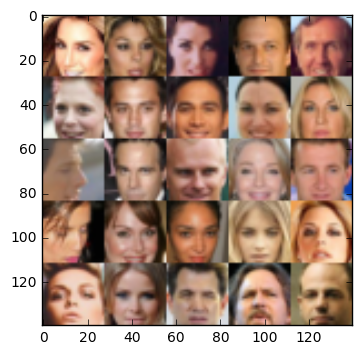

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, 
                                 (None, image_width, image_height, image_channels),
                                 name='input_real') 
    
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    learning_rate = tf.placeholder(tf.float32)
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.1
        
        # Input layer is 28x28x(1 for MNIST, 3 for face)
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128

        # Flatten it
        flat = tf.reshape(x2, (-1, 7*7*256))
        dropout = tf.layers.dropout(flat, rate=0.5)
        logits = tf.layers.dense(dropout, 1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [51]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.1
    if is_train==True:
        reuse=False
    else:
        reuse=True
        
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*64, 
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 64))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now

        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=1, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x2 = tf.layers.dropout(x2, 0.5)
        
        x2 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x2 = tf.layers.conv2d_transpose(x2, 32, 5, strides=1, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x2 = tf.layers.dropout(x2, 0.5)
        
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out    



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [52]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.random_uniform(tf.shape(d_model_real),0.8,1.2)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.random_uniform(tf.shape(d_model_fake),0,0.2)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.random_uniform(tf.shape(d_model_fake),0.8,1.2)))

    d_loss = d_loss_real + d_loss_fake    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [53]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [54]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [75]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
   
    # TODO: Build Model
    tf.reset_default_graph()
    # create input placeholders
    if data_image_mode=="RGB":
        out_channel_dim=3
    else:
        out_channel_dim=1
        
    input_real, input_z, lr_place=model_inputs(data_shape[2], data_shape[1], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
        
    # Training
    saver = tf.train.Saver()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    print_every=10
    show_every=150
    steps = 0        
    n_images=16
    sample_z=tf.Variable(tf.random_uniform(shape=(n_images,z_dim),minval=-1,maxval=1))
    #sample_z = np.random.uniform(-1, 1, size=(50, z_dim))
    with sess.as_default():
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                # rescale the image ouput from +-0.5 to +-1.0
                batch_images=batch_images*2
                
                # Sample random noise for G
                steps+=1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    batch_z = np.random.uniform(-1, 1, size=(n_images, z_dim))
                    show_generator_output(sess, n_images, sample_z, out_channel_dim, data_image_mode)
            #saver.save(sess, './checkpoints/generator.ckpt')


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8406... Generator Loss: 6.4863
Epoch 1/2... Discriminator Loss: 0.4631... Generator Loss: 1.1043
Epoch 1/2... Discriminator Loss: 1.6971... Generator Loss: 3.0290
Epoch 1/2... Discriminator Loss: 0.7769... Generator Loss: 3.4846
Epoch 1/2... Discriminator Loss: 0.4627... Generator Loss: 2.8931
Epoch 1/2... Discriminator Loss: 0.5609... Generator Loss: 1.6863
Epoch 1/2... Discriminator Loss: 1.0476... Generator Loss: 0.5507
Epoch 1/2... Discriminator Loss: 0.5614... Generator Loss: 1.0809
Epoch 1/2... Discriminator Loss: 0.4942... Generator Loss: 1.3795
Epoch 1/2... Discriminator Loss: 0.5092... Generator Loss: 0.9344
Epoch 1/2... Discriminator Loss: 1.7776... Generator Loss: 0.2013
Epoch 1/2... Discriminator Loss: 0.4920... Generator Loss: 1.3767
Epoch 1/2... Discriminator Loss: 0.9020... Generator Loss: 1.0486
Epoch 1/2... Discriminator Loss: 1.0414... Generator Loss: 0.6303
Epoch 1/2... Discriminator Loss: 0.9600... Generator Loss: 2.9815


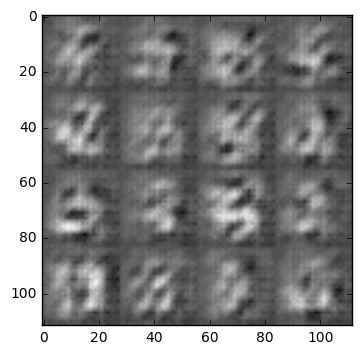

Epoch 1/2... Discriminator Loss: 0.7297... Generator Loss: 1.0478
Epoch 1/2... Discriminator Loss: 0.8955... Generator Loss: 2.1251
Epoch 1/2... Discriminator Loss: 0.6240... Generator Loss: 0.9749
Epoch 1/2... Discriminator Loss: 0.6180... Generator Loss: 1.4910
Epoch 1/2... Discriminator Loss: 0.8489... Generator Loss: 0.8345
Epoch 1/2... Discriminator Loss: 0.6980... Generator Loss: 1.8276
Epoch 1/2... Discriminator Loss: 0.7486... Generator Loss: 0.9404
Epoch 1/2... Discriminator Loss: 0.5684... Generator Loss: 1.4947
Epoch 1/2... Discriminator Loss: 0.7976... Generator Loss: 1.6173
Epoch 1/2... Discriminator Loss: 1.2125... Generator Loss: 0.4215
Epoch 1/2... Discriminator Loss: 0.9344... Generator Loss: 0.5975
Epoch 1/2... Discriminator Loss: 0.8737... Generator Loss: 0.7438
Epoch 1/2... Discriminator Loss: 0.9892... Generator Loss: 0.6671
Epoch 1/2... Discriminator Loss: 0.8546... Generator Loss: 0.8179
Epoch 1/2... Discriminator Loss: 0.8613... Generator Loss: 1.7354


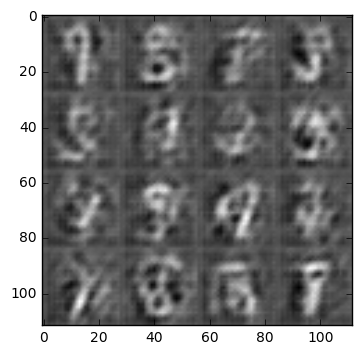

Epoch 1/2... Discriminator Loss: 0.7512... Generator Loss: 1.2880
Epoch 1/2... Discriminator Loss: 0.8383... Generator Loss: 2.0095
Epoch 1/2... Discriminator Loss: 0.8297... Generator Loss: 1.0545
Epoch 1/2... Discriminator Loss: 1.3397... Generator Loss: 0.3907
Epoch 1/2... Discriminator Loss: 1.1171... Generator Loss: 0.4898
Epoch 1/2... Discriminator Loss: 0.7701... Generator Loss: 1.4237
Epoch 1/2... Discriminator Loss: 1.1576... Generator Loss: 0.4602
Epoch 1/2... Discriminator Loss: 1.0605... Generator Loss: 0.5082
Epoch 1/2... Discriminator Loss: 0.8228... Generator Loss: 1.3700
Epoch 1/2... Discriminator Loss: 0.8279... Generator Loss: 1.1911
Epoch 1/2... Discriminator Loss: 1.4204... Generator Loss: 0.2781
Epoch 1/2... Discriminator Loss: 0.7363... Generator Loss: 0.9055
Epoch 1/2... Discriminator Loss: 0.8158... Generator Loss: 1.0758
Epoch 1/2... Discriminator Loss: 1.3041... Generator Loss: 0.4542
Epoch 1/2... Discriminator Loss: 1.0429... Generator Loss: 2.1665


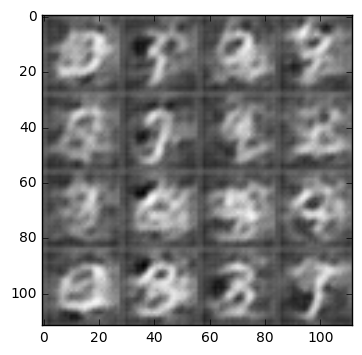

Epoch 1/2... Discriminator Loss: 1.1427... Generator Loss: 0.5141
Epoch 1/2... Discriminator Loss: 1.0378... Generator Loss: 0.7327
Epoch 1/2... Discriminator Loss: 0.8262... Generator Loss: 1.2083
Epoch 1/2... Discriminator Loss: 1.1472... Generator Loss: 0.9996
Epoch 1/2... Discriminator Loss: 1.1592... Generator Loss: 0.5181
Epoch 1/2... Discriminator Loss: 1.3853... Generator Loss: 0.4395
Epoch 1/2... Discriminator Loss: 0.9408... Generator Loss: 0.7397
Epoch 1/2... Discriminator Loss: 1.0008... Generator Loss: 0.6797
Epoch 1/2... Discriminator Loss: 1.0613... Generator Loss: 0.5520
Epoch 1/2... Discriminator Loss: 1.1172... Generator Loss: 0.6306
Epoch 1/2... Discriminator Loss: 1.7185... Generator Loss: 0.2472
Epoch 1/2... Discriminator Loss: 0.9869... Generator Loss: 0.9353
Epoch 1/2... Discriminator Loss: 0.8877... Generator Loss: 1.3383
Epoch 1/2... Discriminator Loss: 0.8205... Generator Loss: 1.0765
Epoch 1/2... Discriminator Loss: 1.9384... Generator Loss: 0.1385


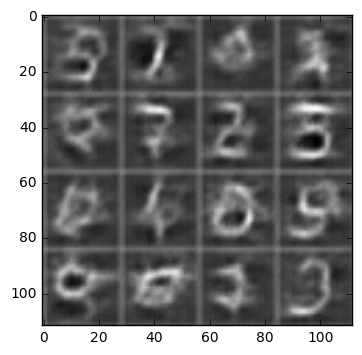

Epoch 1/2... Discriminator Loss: 0.8913... Generator Loss: 1.2216
Epoch 1/2... Discriminator Loss: 1.1389... Generator Loss: 0.7484
Epoch 1/2... Discriminator Loss: 1.2136... Generator Loss: 0.9365
Epoch 1/2... Discriminator Loss: 0.9402... Generator Loss: 0.8158
Epoch 1/2... Discriminator Loss: 0.9182... Generator Loss: 0.7779
Epoch 1/2... Discriminator Loss: 1.1025... Generator Loss: 1.1511
Epoch 1/2... Discriminator Loss: 1.7114... Generator Loss: 1.5203
Epoch 1/2... Discriminator Loss: 1.0363... Generator Loss: 0.7330
Epoch 1/2... Discriminator Loss: 1.4907... Generator Loss: 0.2785
Epoch 1/2... Discriminator Loss: 0.9624... Generator Loss: 0.6615
Epoch 1/2... Discriminator Loss: 1.3897... Generator Loss: 0.3291
Epoch 1/2... Discriminator Loss: 0.9725... Generator Loss: 0.5932
Epoch 1/2... Discriminator Loss: 1.0868... Generator Loss: 0.8764
Epoch 1/2... Discriminator Loss: 0.9133... Generator Loss: 0.9583
Epoch 1/2... Discriminator Loss: 0.9873... Generator Loss: 0.6157


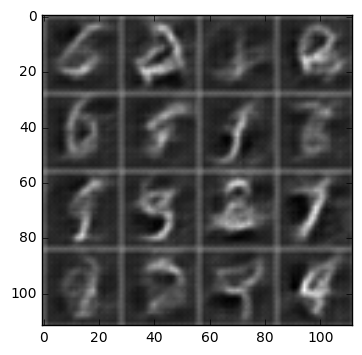

Epoch 1/2... Discriminator Loss: 0.9880... Generator Loss: 0.7805
Epoch 1/2... Discriminator Loss: 1.0389... Generator Loss: 0.7197
Epoch 1/2... Discriminator Loss: 1.0117... Generator Loss: 1.3922
Epoch 1/2... Discriminator Loss: 0.9876... Generator Loss: 1.4255
Epoch 1/2... Discriminator Loss: 1.0477... Generator Loss: 0.8997
Epoch 1/2... Discriminator Loss: 1.0071... Generator Loss: 0.8212
Epoch 1/2... Discriminator Loss: 1.1033... Generator Loss: 0.6343
Epoch 1/2... Discriminator Loss: 1.4045... Generator Loss: 0.3917
Epoch 1/2... Discriminator Loss: 1.1064... Generator Loss: 1.3472
Epoch 1/2... Discriminator Loss: 0.9501... Generator Loss: 0.9030
Epoch 1/2... Discriminator Loss: 0.9014... Generator Loss: 0.7331
Epoch 1/2... Discriminator Loss: 0.9057... Generator Loss: 0.7290
Epoch 1/2... Discriminator Loss: 1.0026... Generator Loss: 0.7329
Epoch 1/2... Discriminator Loss: 1.3308... Generator Loss: 0.3416
Epoch 1/2... Discriminator Loss: 0.8235... Generator Loss: 0.8274


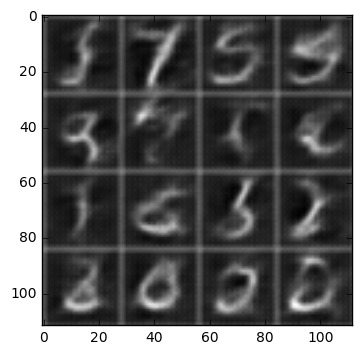

Epoch 1/2... Discriminator Loss: 0.9860... Generator Loss: 1.4394
Epoch 1/2... Discriminator Loss: 2.6298... Generator Loss: 0.0239
Epoch 1/2... Discriminator Loss: 1.0577... Generator Loss: 0.6593
Epoch 1/2... Discriminator Loss: 1.0286... Generator Loss: 0.7835
Epoch 1/2... Discriminator Loss: 0.8381... Generator Loss: 1.2187
Epoch 1/2... Discriminator Loss: 1.0770... Generator Loss: 0.5914
Epoch 1/2... Discriminator Loss: 1.0528... Generator Loss: 0.7475
Epoch 1/2... Discriminator Loss: 0.9170... Generator Loss: 0.9386
Epoch 1/2... Discriminator Loss: 1.2547... Generator Loss: 0.4041
Epoch 1/2... Discriminator Loss: 2.0307... Generator Loss: 0.1990
Epoch 1/2... Discriminator Loss: 1.1023... Generator Loss: 0.7231
Epoch 1/2... Discriminator Loss: 1.0817... Generator Loss: 1.4637
Epoch 1/2... Discriminator Loss: 0.9545... Generator Loss: 0.7965
Epoch 1/2... Discriminator Loss: 1.2715... Generator Loss: 0.5212
Epoch 1/2... Discriminator Loss: 0.9065... Generator Loss: 1.0312


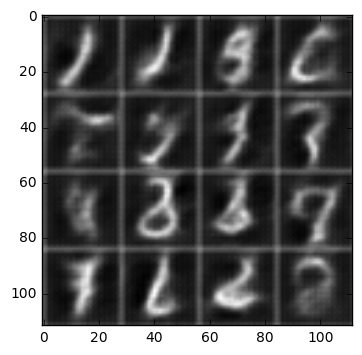

Epoch 1/2... Discriminator Loss: 1.0140... Generator Loss: 0.8833
Epoch 1/2... Discriminator Loss: 1.1207... Generator Loss: 0.5902
Epoch 1/2... Discriminator Loss: 0.9574... Generator Loss: 0.8470
Epoch 1/2... Discriminator Loss: 0.8329... Generator Loss: 1.0733
Epoch 1/2... Discriminator Loss: 1.1385... Generator Loss: 1.4835
Epoch 1/2... Discriminator Loss: 1.2640... Generator Loss: 1.2542
Epoch 1/2... Discriminator Loss: 1.0270... Generator Loss: 2.0577
Epoch 1/2... Discriminator Loss: 1.4405... Generator Loss: 0.4736
Epoch 1/2... Discriminator Loss: 1.2417... Generator Loss: 0.5050
Epoch 1/2... Discriminator Loss: 0.8969... Generator Loss: 1.0910
Epoch 1/2... Discriminator Loss: 0.9571... Generator Loss: 0.8781
Epoch 1/2... Discriminator Loss: 0.9862... Generator Loss: 0.7227
Epoch 1/2... Discriminator Loss: 0.9165... Generator Loss: 0.8454
Epoch 1/2... Discriminator Loss: 1.0298... Generator Loss: 0.6583
Epoch 1/2... Discriminator Loss: 1.0173... Generator Loss: 0.6780


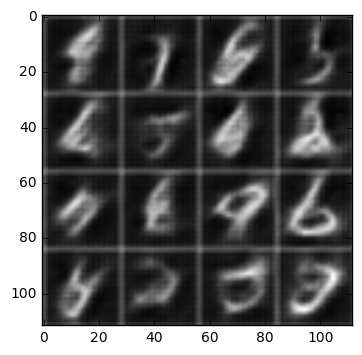

Epoch 1/2... Discriminator Loss: 0.8796... Generator Loss: 0.8153
Epoch 1/2... Discriminator Loss: 1.5433... Generator Loss: 1.5284
Epoch 1/2... Discriminator Loss: 0.9895... Generator Loss: 0.8644
Epoch 1/2... Discriminator Loss: 0.9886... Generator Loss: 0.7735
Epoch 1/2... Discriminator Loss: 0.8795... Generator Loss: 1.2676
Epoch 1/2... Discriminator Loss: 0.9694... Generator Loss: 0.7042
Epoch 1/2... Discriminator Loss: 1.1374... Generator Loss: 0.5696
Epoch 1/2... Discriminator Loss: 0.9027... Generator Loss: 0.6947
Epoch 1/2... Discriminator Loss: 1.1558... Generator Loss: 1.3386
Epoch 1/2... Discriminator Loss: 0.9095... Generator Loss: 0.9377
Epoch 1/2... Discriminator Loss: 0.9041... Generator Loss: 1.3433
Epoch 1/2... Discriminator Loss: 1.1468... Generator Loss: 0.6542
Epoch 1/2... Discriminator Loss: 1.0024... Generator Loss: 1.0982
Epoch 1/2... Discriminator Loss: 1.0124... Generator Loss: 0.5984
Epoch 1/2... Discriminator Loss: 1.2593... Generator Loss: 0.5324


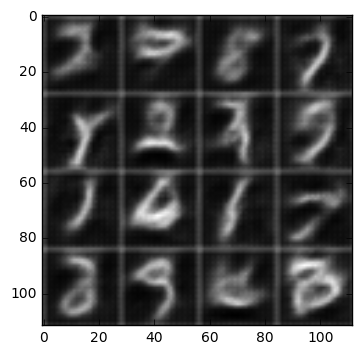

Epoch 1/2... Discriminator Loss: 1.3842... Generator Loss: 0.3963
Epoch 1/2... Discriminator Loss: 1.1857... Generator Loss: 0.5178
Epoch 1/2... Discriminator Loss: 0.8541... Generator Loss: 1.0370
Epoch 1/2... Discriminator Loss: 1.0047... Generator Loss: 1.1044
Epoch 1/2... Discriminator Loss: 1.4331... Generator Loss: 0.3588
Epoch 1/2... Discriminator Loss: 0.9746... Generator Loss: 0.7287
Epoch 1/2... Discriminator Loss: 1.5936... Generator Loss: 0.2941
Epoch 1/2... Discriminator Loss: 0.9741... Generator Loss: 0.7181
Epoch 1/2... Discriminator Loss: 1.0971... Generator Loss: 1.2171
Epoch 1/2... Discriminator Loss: 0.8847... Generator Loss: 1.1557
Epoch 1/2... Discriminator Loss: 1.1437... Generator Loss: 0.5694
Epoch 1/2... Discriminator Loss: 1.1240... Generator Loss: 0.4824
Epoch 1/2... Discriminator Loss: 1.1538... Generator Loss: 1.1751
Epoch 1/2... Discriminator Loss: 1.0498... Generator Loss: 0.6310
Epoch 1/2... Discriminator Loss: 1.0145... Generator Loss: 0.9739


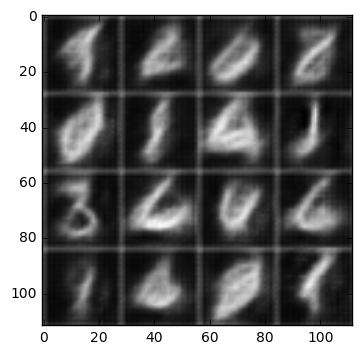

Epoch 1/2... Discriminator Loss: 1.1155... Generator Loss: 0.8037
Epoch 1/2... Discriminator Loss: 0.9916... Generator Loss: 0.7267
Epoch 1/2... Discriminator Loss: 1.0556... Generator Loss: 0.8113
Epoch 1/2... Discriminator Loss: 0.8204... Generator Loss: 0.8723
Epoch 1/2... Discriminator Loss: 0.8831... Generator Loss: 1.0782
Epoch 1/2... Discriminator Loss: 0.8407... Generator Loss: 0.7846
Epoch 1/2... Discriminator Loss: 1.0673... Generator Loss: 1.1692
Epoch 1/2... Discriminator Loss: 1.0068... Generator Loss: 1.1141
Epoch 1/2... Discriminator Loss: 1.1767... Generator Loss: 1.2810
Epoch 1/2... Discriminator Loss: 1.1314... Generator Loss: 1.3289
Epoch 1/2... Discriminator Loss: 1.1235... Generator Loss: 1.0432
Epoch 1/2... Discriminator Loss: 0.9053... Generator Loss: 0.9620
Epoch 1/2... Discriminator Loss: 0.9609... Generator Loss: 1.0489
Epoch 1/2... Discriminator Loss: 1.0419... Generator Loss: 0.7708
Epoch 1/2... Discriminator Loss: 0.7911... Generator Loss: 1.2317


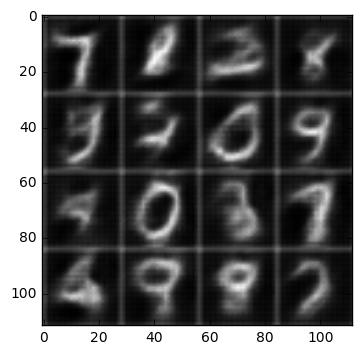

Epoch 1/2... Discriminator Loss: 1.0564... Generator Loss: 0.7029
Epoch 1/2... Discriminator Loss: 0.9688... Generator Loss: 1.2276
Epoch 1/2... Discriminator Loss: 0.5772... Generator Loss: 1.1342
Epoch 1/2... Discriminator Loss: 1.1009... Generator Loss: 1.5884
Epoch 1/2... Discriminator Loss: 0.9460... Generator Loss: 0.7397
Epoch 1/2... Discriminator Loss: 0.9704... Generator Loss: 0.8575
Epoch 1/2... Discriminator Loss: 1.2169... Generator Loss: 1.4913
Epoch 1/2... Discriminator Loss: 1.1222... Generator Loss: 0.5458
Epoch 1/2... Discriminator Loss: 0.8712... Generator Loss: 1.1928
Epoch 1/2... Discriminator Loss: 1.0667... Generator Loss: 0.7079
Epoch 1/2... Discriminator Loss: 1.1352... Generator Loss: 0.5287
Epoch 1/2... Discriminator Loss: 1.0549... Generator Loss: 0.6077
Epoch 1/2... Discriminator Loss: 0.9803... Generator Loss: 0.7790
Epoch 1/2... Discriminator Loss: 0.8551... Generator Loss: 1.0084
Epoch 1/2... Discriminator Loss: 0.8477... Generator Loss: 1.3262


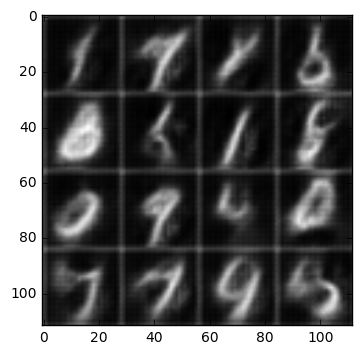

Epoch 1/2... Discriminator Loss: 1.0394... Generator Loss: 0.8576
Epoch 1/2... Discriminator Loss: 1.1497... Generator Loss: 0.5331
Epoch 1/2... Discriminator Loss: 1.3045... Generator Loss: 0.4761
Epoch 1/2... Discriminator Loss: 1.1293... Generator Loss: 0.9499
Epoch 1/2... Discriminator Loss: 1.0639... Generator Loss: 0.7114
Epoch 1/2... Discriminator Loss: 1.2565... Generator Loss: 0.4879
Epoch 1/2... Discriminator Loss: 0.9827... Generator Loss: 0.5651
Epoch 2/2... Discriminator Loss: 0.8166... Generator Loss: 0.9153
Epoch 2/2... Discriminator Loss: 1.0413... Generator Loss: 0.8513
Epoch 2/2... Discriminator Loss: 1.1929... Generator Loss: 0.5254
Epoch 2/2... Discriminator Loss: 0.8983... Generator Loss: 0.7217
Epoch 2/2... Discriminator Loss: 1.1735... Generator Loss: 0.5090
Epoch 2/2... Discriminator Loss: 1.0947... Generator Loss: 1.6196
Epoch 2/2... Discriminator Loss: 1.1609... Generator Loss: 0.5597
Epoch 2/2... Discriminator Loss: 1.4437... Generator Loss: 0.2607


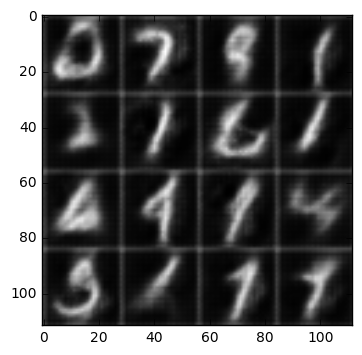

Epoch 2/2... Discriminator Loss: 1.1450... Generator Loss: 0.4924
Epoch 2/2... Discriminator Loss: 1.3602... Generator Loss: 0.3783
Epoch 2/2... Discriminator Loss: 1.1567... Generator Loss: 0.5699
Epoch 2/2... Discriminator Loss: 0.9577... Generator Loss: 0.7824
Epoch 2/2... Discriminator Loss: 0.9227... Generator Loss: 1.1873
Epoch 2/2... Discriminator Loss: 1.5185... Generator Loss: 1.7650
Epoch 2/2... Discriminator Loss: 1.1128... Generator Loss: 1.2421
Epoch 2/2... Discriminator Loss: 1.4417... Generator Loss: 1.1564
Epoch 2/2... Discriminator Loss: 0.9757... Generator Loss: 1.1246
Epoch 2/2... Discriminator Loss: 1.2271... Generator Loss: 0.4573
Epoch 2/2... Discriminator Loss: 0.7814... Generator Loss: 0.8451
Epoch 2/2... Discriminator Loss: 1.0664... Generator Loss: 1.4074
Epoch 2/2... Discriminator Loss: 1.0349... Generator Loss: 1.2411
Epoch 2/2... Discriminator Loss: 1.1909... Generator Loss: 0.4441
Epoch 2/2... Discriminator Loss: 0.9176... Generator Loss: 1.2030


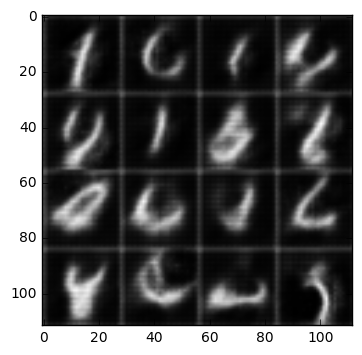

Epoch 2/2... Discriminator Loss: 1.0407... Generator Loss: 1.3875
Epoch 2/2... Discriminator Loss: 1.0391... Generator Loss: 1.0077
Epoch 2/2... Discriminator Loss: 0.7520... Generator Loss: 1.1275
Epoch 2/2... Discriminator Loss: 1.0589... Generator Loss: 1.6658
Epoch 2/2... Discriminator Loss: 1.1841... Generator Loss: 0.6418
Epoch 2/2... Discriminator Loss: 1.1612... Generator Loss: 1.6130
Epoch 2/2... Discriminator Loss: 1.2869... Generator Loss: 0.5195
Epoch 2/2... Discriminator Loss: 0.9924... Generator Loss: 1.5129
Epoch 2/2... Discriminator Loss: 0.7812... Generator Loss: 1.1282
Epoch 2/2... Discriminator Loss: 1.3925... Generator Loss: 0.4005
Epoch 2/2... Discriminator Loss: 1.0197... Generator Loss: 0.6978
Epoch 2/2... Discriminator Loss: 0.8902... Generator Loss: 1.2309
Epoch 2/2... Discriminator Loss: 1.3549... Generator Loss: 0.4136
Epoch 2/2... Discriminator Loss: 0.7879... Generator Loss: 1.0161
Epoch 2/2... Discriminator Loss: 1.0921... Generator Loss: 1.5528


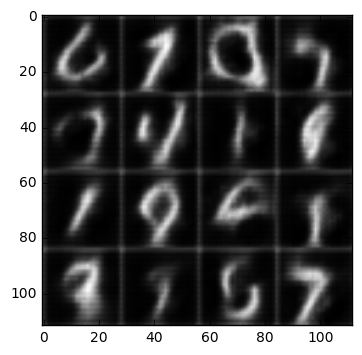

Epoch 2/2... Discriminator Loss: 1.0277... Generator Loss: 1.1441
Epoch 2/2... Discriminator Loss: 0.8948... Generator Loss: 0.8475
Epoch 2/2... Discriminator Loss: 1.0293... Generator Loss: 0.6781
Epoch 2/2... Discriminator Loss: 1.0955... Generator Loss: 0.6007
Epoch 2/2... Discriminator Loss: 1.0384... Generator Loss: 0.6360
Epoch 2/2... Discriminator Loss: 1.1782... Generator Loss: 0.4812
Epoch 2/2... Discriminator Loss: 1.0324... Generator Loss: 0.7881
Epoch 2/2... Discriminator Loss: 1.0596... Generator Loss: 0.6636
Epoch 2/2... Discriminator Loss: 1.1050... Generator Loss: 1.1355
Epoch 2/2... Discriminator Loss: 0.9960... Generator Loss: 0.5984
Epoch 2/2... Discriminator Loss: 0.9631... Generator Loss: 0.7443
Epoch 2/2... Discriminator Loss: 1.1015... Generator Loss: 0.5993
Epoch 2/2... Discriminator Loss: 0.9662... Generator Loss: 0.8884
Epoch 2/2... Discriminator Loss: 0.9365... Generator Loss: 0.6801
Epoch 2/2... Discriminator Loss: 1.0378... Generator Loss: 0.8976


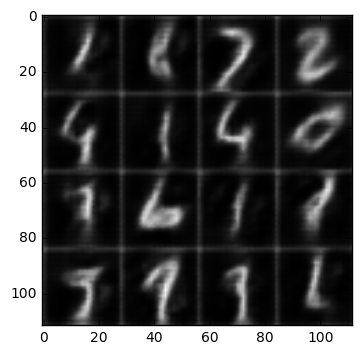

Epoch 2/2... Discriminator Loss: 0.7987... Generator Loss: 0.9982
Epoch 2/2... Discriminator Loss: 1.0016... Generator Loss: 0.8308
Epoch 2/2... Discriminator Loss: 1.4414... Generator Loss: 0.3902
Epoch 2/2... Discriminator Loss: 1.2033... Generator Loss: 0.7786
Epoch 2/2... Discriminator Loss: 1.1138... Generator Loss: 0.6046
Epoch 2/2... Discriminator Loss: 0.9995... Generator Loss: 0.7499
Epoch 2/2... Discriminator Loss: 0.9936... Generator Loss: 0.9131
Epoch 2/2... Discriminator Loss: 1.0304... Generator Loss: 0.9146
Epoch 2/2... Discriminator Loss: 1.0116... Generator Loss: 0.5843
Epoch 2/2... Discriminator Loss: 1.2400... Generator Loss: 0.4687
Epoch 2/2... Discriminator Loss: 1.1867... Generator Loss: 0.9783
Epoch 2/2... Discriminator Loss: 0.8790... Generator Loss: 0.9506
Epoch 2/2... Discriminator Loss: 1.0120... Generator Loss: 0.9235
Epoch 2/2... Discriminator Loss: 1.0336... Generator Loss: 1.2316
Epoch 2/2... Discriminator Loss: 1.2710... Generator Loss: 0.4193


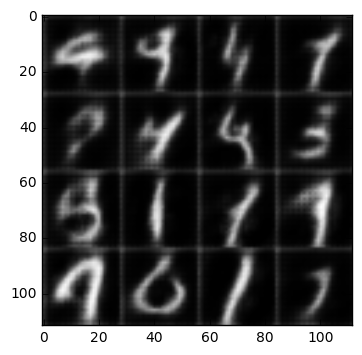

Epoch 2/2... Discriminator Loss: 0.9405... Generator Loss: 0.8444
Epoch 2/2... Discriminator Loss: 0.9884... Generator Loss: 0.7193
Epoch 2/2... Discriminator Loss: 1.0753... Generator Loss: 1.2580
Epoch 2/2... Discriminator Loss: 1.0774... Generator Loss: 0.4768
Epoch 2/2... Discriminator Loss: 1.2291... Generator Loss: 0.4440
Epoch 2/2... Discriminator Loss: 0.8454... Generator Loss: 1.1020
Epoch 2/2... Discriminator Loss: 1.0448... Generator Loss: 0.6448
Epoch 2/2... Discriminator Loss: 1.4769... Generator Loss: 0.2605
Epoch 2/2... Discriminator Loss: 0.9694... Generator Loss: 0.8203
Epoch 2/2... Discriminator Loss: 1.0453... Generator Loss: 0.7027
Epoch 2/2... Discriminator Loss: 1.0528... Generator Loss: 1.2111
Epoch 2/2... Discriminator Loss: 1.2378... Generator Loss: 0.4048
Epoch 2/2... Discriminator Loss: 1.0666... Generator Loss: 0.8092
Epoch 2/2... Discriminator Loss: 0.9080... Generator Loss: 0.9772
Epoch 2/2... Discriminator Loss: 1.2078... Generator Loss: 0.5245


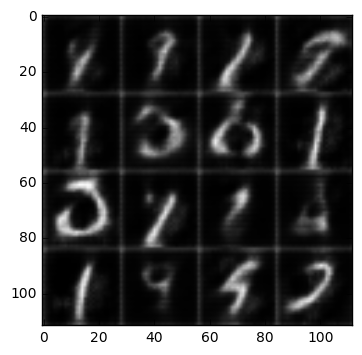

Epoch 2/2... Discriminator Loss: 0.7875... Generator Loss: 0.7615
Epoch 2/2... Discriminator Loss: 1.4844... Generator Loss: 1.8043
Epoch 2/2... Discriminator Loss: 1.1164... Generator Loss: 0.5813
Epoch 2/2... Discriminator Loss: 1.0114... Generator Loss: 1.5109
Epoch 2/2... Discriminator Loss: 0.7782... Generator Loss: 1.1605
Epoch 2/2... Discriminator Loss: 1.1246... Generator Loss: 0.4634
Epoch 2/2... Discriminator Loss: 1.0498... Generator Loss: 0.6079
Epoch 2/2... Discriminator Loss: 0.9084... Generator Loss: 0.8504
Epoch 2/2... Discriminator Loss: 1.1644... Generator Loss: 0.5387
Epoch 2/2... Discriminator Loss: 0.9475... Generator Loss: 0.8570
Epoch 2/2... Discriminator Loss: 1.1261... Generator Loss: 0.6769
Epoch 2/2... Discriminator Loss: 1.1813... Generator Loss: 1.1002
Epoch 2/2... Discriminator Loss: 1.0298... Generator Loss: 0.7761
Epoch 2/2... Discriminator Loss: 0.9381... Generator Loss: 1.2626
Epoch 2/2... Discriminator Loss: 0.8359... Generator Loss: 0.7775


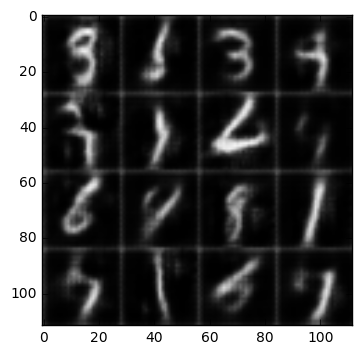

Epoch 2/2... Discriminator Loss: 1.1981... Generator Loss: 0.6444
Epoch 2/2... Discriminator Loss: 0.9566... Generator Loss: 1.3153
Epoch 2/2... Discriminator Loss: 0.9171... Generator Loss: 0.9862
Epoch 2/2... Discriminator Loss: 1.0157... Generator Loss: 1.2053
Epoch 2/2... Discriminator Loss: 1.0651... Generator Loss: 1.1616
Epoch 2/2... Discriminator Loss: 0.9730... Generator Loss: 0.6376
Epoch 2/2... Discriminator Loss: 1.2872... Generator Loss: 1.2648
Epoch 2/2... Discriminator Loss: 0.9555... Generator Loss: 0.8299
Epoch 2/2... Discriminator Loss: 1.1579... Generator Loss: 0.7882
Epoch 2/2... Discriminator Loss: 0.7201... Generator Loss: 0.8728
Epoch 2/2... Discriminator Loss: 0.9133... Generator Loss: 0.8583
Epoch 2/2... Discriminator Loss: 1.2019... Generator Loss: 1.4848
Epoch 2/2... Discriminator Loss: 0.9627... Generator Loss: 0.7912
Epoch 2/2... Discriminator Loss: 1.1216... Generator Loss: 1.1659
Epoch 2/2... Discriminator Loss: 1.0326... Generator Loss: 1.2909


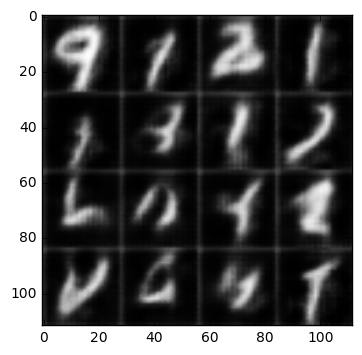

Epoch 2/2... Discriminator Loss: 1.2207... Generator Loss: 1.4526
Epoch 2/2... Discriminator Loss: 0.9429... Generator Loss: 0.9487
Epoch 2/2... Discriminator Loss: 0.8312... Generator Loss: 1.2175
Epoch 2/2... Discriminator Loss: 1.3250... Generator Loss: 0.3364
Epoch 2/2... Discriminator Loss: 1.0164... Generator Loss: 0.8311
Epoch 2/2... Discriminator Loss: 0.9724... Generator Loss: 0.8389
Epoch 2/2... Discriminator Loss: 0.8261... Generator Loss: 0.9308
Epoch 2/2... Discriminator Loss: 0.9665... Generator Loss: 1.1244
Epoch 2/2... Discriminator Loss: 1.2059... Generator Loss: 0.5323
Epoch 2/2... Discriminator Loss: 1.0015... Generator Loss: 0.8722
Epoch 2/2... Discriminator Loss: 1.1008... Generator Loss: 0.6209
Epoch 2/2... Discriminator Loss: 0.9563... Generator Loss: 0.7677
Epoch 2/2... Discriminator Loss: 1.1536... Generator Loss: 0.6506
Epoch 2/2... Discriminator Loss: 1.2074... Generator Loss: 0.7043
Epoch 2/2... Discriminator Loss: 1.0102... Generator Loss: 0.8172


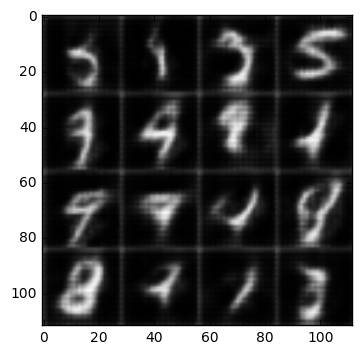

Epoch 2/2... Discriminator Loss: 1.1283... Generator Loss: 0.6321
Epoch 2/2... Discriminator Loss: 0.9568... Generator Loss: 0.8614
Epoch 2/2... Discriminator Loss: 1.1151... Generator Loss: 0.6614
Epoch 2/2... Discriminator Loss: 1.0519... Generator Loss: 0.9425
Epoch 2/2... Discriminator Loss: 1.2227... Generator Loss: 0.6960
Epoch 2/2... Discriminator Loss: 1.1829... Generator Loss: 0.4536
Epoch 2/2... Discriminator Loss: 1.1843... Generator Loss: 0.6316
Epoch 2/2... Discriminator Loss: 1.0929... Generator Loss: 1.1310
Epoch 2/2... Discriminator Loss: 1.0512... Generator Loss: 0.8521
Epoch 2/2... Discriminator Loss: 1.0242... Generator Loss: 0.5915
Epoch 2/2... Discriminator Loss: 0.9274... Generator Loss: 0.7261
Epoch 2/2... Discriminator Loss: 1.0275... Generator Loss: 0.6131
Epoch 2/2... Discriminator Loss: 0.8948... Generator Loss: 1.1980
Epoch 2/2... Discriminator Loss: 0.8614... Generator Loss: 0.7498
Epoch 2/2... Discriminator Loss: 0.9028... Generator Loss: 0.9782


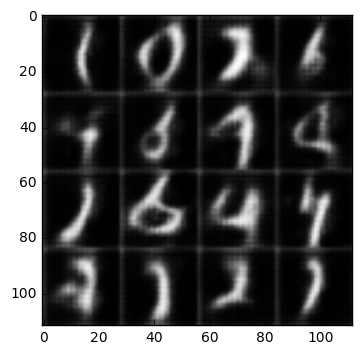

Epoch 2/2... Discriminator Loss: 1.0557... Generator Loss: 0.5627
Epoch 2/2... Discriminator Loss: 0.8638... Generator Loss: 1.2044
Epoch 2/2... Discriminator Loss: 1.0591... Generator Loss: 0.9894
Epoch 2/2... Discriminator Loss: 0.8131... Generator Loss: 1.0415
Epoch 2/2... Discriminator Loss: 1.0997... Generator Loss: 0.7256
Epoch 2/2... Discriminator Loss: 0.9179... Generator Loss: 0.7264
Epoch 2/2... Discriminator Loss: 1.1612... Generator Loss: 1.2922
Epoch 2/2... Discriminator Loss: 0.9652... Generator Loss: 0.8933
Epoch 2/2... Discriminator Loss: 0.9090... Generator Loss: 1.0261
Epoch 2/2... Discriminator Loss: 1.0442... Generator Loss: 0.5709
Epoch 2/2... Discriminator Loss: 0.9135... Generator Loss: 0.7604
Epoch 2/2... Discriminator Loss: 0.9130... Generator Loss: 0.9630
Epoch 2/2... Discriminator Loss: 1.3683... Generator Loss: 0.4278
Epoch 2/2... Discriminator Loss: 1.3636... Generator Loss: 0.3439
Epoch 2/2... Discriminator Loss: 1.3758... Generator Loss: 1.2298


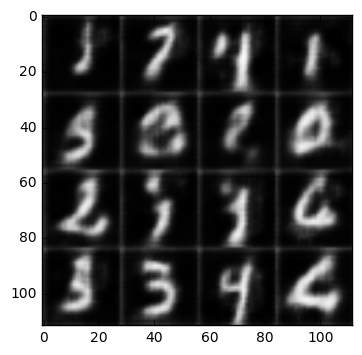

Epoch 2/2... Discriminator Loss: 1.0963... Generator Loss: 0.9147
Epoch 2/2... Discriminator Loss: 1.0306... Generator Loss: 0.8911
Epoch 2/2... Discriminator Loss: 1.0466... Generator Loss: 0.9519
Epoch 2/2... Discriminator Loss: 1.0960... Generator Loss: 1.1139
Epoch 2/2... Discriminator Loss: 1.1122... Generator Loss: 0.6345
Epoch 2/2... Discriminator Loss: 0.7631... Generator Loss: 0.9181
Epoch 2/2... Discriminator Loss: 1.1052... Generator Loss: 0.5117
Epoch 2/2... Discriminator Loss: 1.1588... Generator Loss: 0.4826
Epoch 2/2... Discriminator Loss: 0.8752... Generator Loss: 1.0142
Epoch 2/2... Discriminator Loss: 0.9811... Generator Loss: 0.6303
Epoch 2/2... Discriminator Loss: 1.1386... Generator Loss: 0.5201
Epoch 2/2... Discriminator Loss: 1.1427... Generator Loss: 0.5555
Epoch 2/2... Discriminator Loss: 1.1123... Generator Loss: 0.7978
Epoch 2/2... Discriminator Loss: 1.7883... Generator Loss: 0.1482
Epoch 2/2... Discriminator Loss: 1.0516... Generator Loss: 0.9807


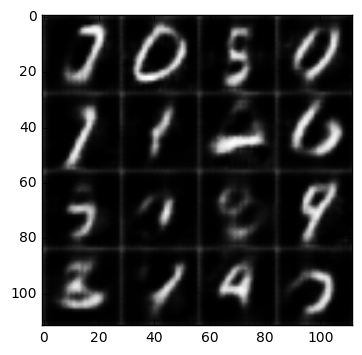

Epoch 2/2... Discriminator Loss: 0.5569... Generator Loss: 1.5101
Epoch 2/2... Discriminator Loss: 1.2113... Generator Loss: 0.8003
Epoch 2/2... Discriminator Loss: 1.0013... Generator Loss: 0.5973
Epoch 2/2... Discriminator Loss: 0.8255... Generator Loss: 0.9304
Epoch 2/2... Discriminator Loss: 1.1245... Generator Loss: 0.6621
Epoch 2/2... Discriminator Loss: 1.1451... Generator Loss: 0.5316
Epoch 2/2... Discriminator Loss: 1.0501... Generator Loss: 0.7105
Epoch 2/2... Discriminator Loss: 1.1566... Generator Loss: 0.5853
Epoch 2/2... Discriminator Loss: 1.0708... Generator Loss: 0.9825
Epoch 2/2... Discriminator Loss: 1.1421... Generator Loss: 0.5884
Epoch 2/2... Discriminator Loss: 1.1280... Generator Loss: 1.6267
Epoch 2/2... Discriminator Loss: 1.3035... Generator Loss: 0.4312
Epoch 2/2... Discriminator Loss: 0.9150... Generator Loss: 0.8692
Epoch 2/2... Discriminator Loss: 1.1600... Generator Loss: 0.4722
Epoch 2/2... Discriminator Loss: 0.9425... Generator Loss: 1.1922


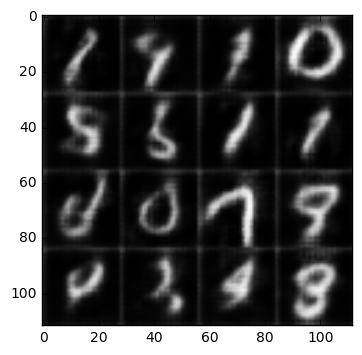

IndexError: list index out of range

In [76]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0072... Generator Loss: 7.4282
Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 0.4058... Generator Loss: 1.6136
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.4222
Epoch 1/1... Discriminator Loss: 1.5523... Generator Loss: 0.3675
Epoch 1/1... Discriminator Loss: 0.6231... Generator Loss: 1.0815
Epoch 1/1... Discriminator Loss: 0.8852... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 0.5018... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.3291
Epoch 1/1... Discriminator Loss: 0.8258... Generator Loss: 3.8978
Epoch 1/1... Discriminator Loss: 0.4050... Generator Loss: 2.1811
Epoch 1/1... Discriminator Loss: 0.6253... Generator Loss: 1.2504
Epoch 1/1... Discriminator Loss: 0.4684... Generator Loss: 1.3493
Epoch 1/1... Discriminator Loss: 0.6466... Generator Loss: 1.7261
Epoch 1/1... Discriminator Loss: 0.4177... Generator Loss: 2.1730


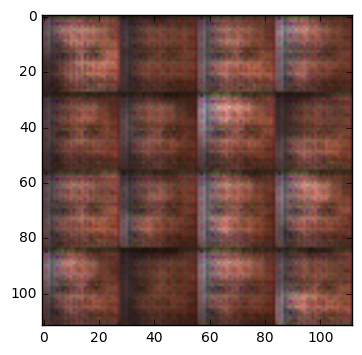

Epoch 1/1... Discriminator Loss: 0.5298... Generator Loss: 1.6685
Epoch 1/1... Discriminator Loss: 0.7395... Generator Loss: 0.8977
Epoch 1/1... Discriminator Loss: 0.7154... Generator Loss: 1.1004
Epoch 1/1... Discriminator Loss: 0.9661... Generator Loss: 0.6522
Epoch 1/1... Discriminator Loss: 0.6423... Generator Loss: 2.3092
Epoch 1/1... Discriminator Loss: 0.6567... Generator Loss: 1.0924
Epoch 1/1... Discriminator Loss: 0.7144... Generator Loss: 1.7015
Epoch 1/1... Discriminator Loss: 0.6358... Generator Loss: 1.7263
Epoch 1/1... Discriminator Loss: 0.6509... Generator Loss: 2.4918
Epoch 1/1... Discriminator Loss: 0.7056... Generator Loss: 0.8848
Epoch 1/1... Discriminator Loss: 0.7697... Generator Loss: 1.0177
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.5839
Epoch 1/1... Discriminator Loss: 0.5957... Generator Loss: 1.1805
Epoch 1/1... Discriminator Loss: 0.5399... Generator Loss: 1.4616
Epoch 1/1... Discriminator Loss: 0.6965... Generator Loss: 3.5754


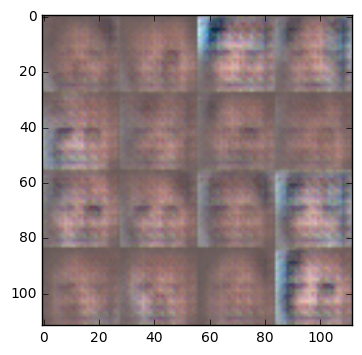

Epoch 1/1... Discriminator Loss: 0.6682... Generator Loss: 1.1514
Epoch 1/1... Discriminator Loss: 0.5924... Generator Loss: 1.8205
Epoch 1/1... Discriminator Loss: 0.8892... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 0.4632... Generator Loss: 2.6148
Epoch 1/1... Discriminator Loss: 0.5919... Generator Loss: 1.3889
Epoch 1/1... Discriminator Loss: 0.7538... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 0.7058... Generator Loss: 1.2992
Epoch 1/1... Discriminator Loss: 1.5311... Generator Loss: 0.4078
Epoch 1/1... Discriminator Loss: 0.7230... Generator Loss: 3.1595
Epoch 1/1... Discriminator Loss: 0.6888... Generator Loss: 1.0581
Epoch 1/1... Discriminator Loss: 0.9896... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 0.8291... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 0.9480... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 1.1025
Epoch 1/1... Discriminator Loss: 1.0026... Generator Loss: 0.6513


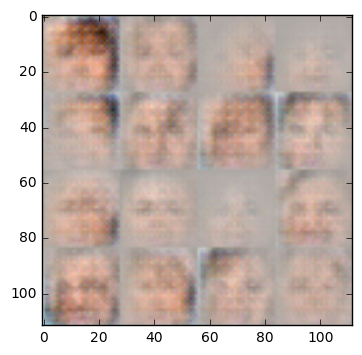

Epoch 1/1... Discriminator Loss: 0.6251... Generator Loss: 1.6362
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 2.9853
Epoch 1/1... Discriminator Loss: 0.5940... Generator Loss: 1.6639
Epoch 1/1... Discriminator Loss: 0.7913... Generator Loss: 1.6172
Epoch 1/1... Discriminator Loss: 0.6738... Generator Loss: 1.5164
Epoch 1/1... Discriminator Loss: 1.1373... Generator Loss: 0.5041
Epoch 1/1... Discriminator Loss: 0.9234... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 0.6823... Generator Loss: 1.0521
Epoch 1/1... Discriminator Loss: 1.1296... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 2.3542... Generator Loss: 0.1401
Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 0.7610... Generator Loss: 1.1706
Epoch 1/1... Discriminator Loss: 0.8668... Generator Loss: 2.3460
Epoch 1/1... Discriminator Loss: 1.0330... Generator Loss: 1.5253
Epoch 1/1... Discriminator Loss: 0.9125... Generator Loss: 0.9166


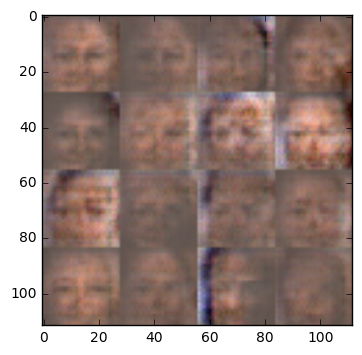

Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 0.4879
Epoch 1/1... Discriminator Loss: 0.7713... Generator Loss: 0.9329
Epoch 1/1... Discriminator Loss: 0.7425... Generator Loss: 2.0912
Epoch 1/1... Discriminator Loss: 0.9447... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 0.5566... Generator Loss: 1.5686
Epoch 1/1... Discriminator Loss: 1.5849... Generator Loss: 3.8182
Epoch 1/1... Discriminator Loss: 0.7147... Generator Loss: 1.0719
Epoch 1/1... Discriminator Loss: 0.9405... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 0.7269... Generator Loss: 1.5949
Epoch 1/1... Discriminator Loss: 0.9275... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 0.7275... Generator Loss: 0.9619
Epoch 1/1... Discriminator Loss: 0.8265... Generator Loss: 1.0543
Epoch 1/1... Discriminator Loss: 1.0604... Generator Loss: 0.5803
Epoch 1/1... Discriminator Loss: 0.9451... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 0.8725... Generator Loss: 2.3771


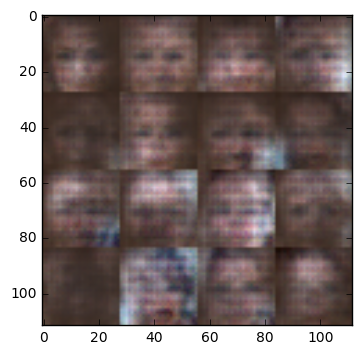

Epoch 1/1... Discriminator Loss: 0.7922... Generator Loss: 1.0344
Epoch 1/1... Discriminator Loss: 0.7897... Generator Loss: 1.1864
Epoch 1/1... Discriminator Loss: 0.8671... Generator Loss: 1.5732
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 0.6174
Epoch 1/1... Discriminator Loss: 0.9282... Generator Loss: 1.8472
Epoch 1/1... Discriminator Loss: 0.8864... Generator Loss: 0.8884
Epoch 1/1... Discriminator Loss: 0.8150... Generator Loss: 1.9877
Epoch 1/1... Discriminator Loss: 0.9743... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 0.9714... Generator Loss: 1.2335
Epoch 1/1... Discriminator Loss: 0.6746... Generator Loss: 2.1170
Epoch 1/1... Discriminator Loss: 0.8553... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 2.9940
Epoch 1/1... Discriminator Loss: 0.8989... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.4903
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 2.3399


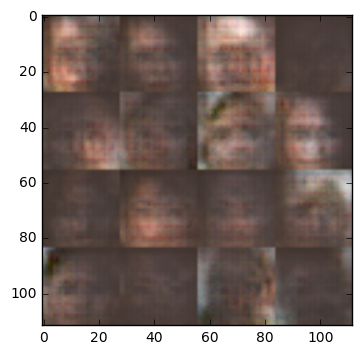

Epoch 1/1... Discriminator Loss: 1.0496... Generator Loss: 0.5279
Epoch 1/1... Discriminator Loss: 0.7528... Generator Loss: 1.1473
Epoch 1/1... Discriminator Loss: 0.8359... Generator Loss: 0.9410
Epoch 1/1... Discriminator Loss: 0.7190... Generator Loss: 0.9008
Epoch 1/1... Discriminator Loss: 0.9085... Generator Loss: 0.9017
Epoch 1/1... Discriminator Loss: 0.9865... Generator Loss: 0.9179
Epoch 1/1... Discriminator Loss: 1.6108... Generator Loss: 0.2672
Epoch 1/1... Discriminator Loss: 0.8835... Generator Loss: 0.8803
Epoch 1/1... Discriminator Loss: 0.7091... Generator Loss: 2.2674
Epoch 1/1... Discriminator Loss: 1.0243... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 0.8929... Generator Loss: 1.2443
Epoch 1/1... Discriminator Loss: 0.8520... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 0.8636... Generator Loss: 1.2126
Epoch 1/1... Discriminator Loss: 0.8973... Generator Loss: 1.1244
Epoch 1/1... Discriminator Loss: 0.9670... Generator Loss: 1.2484


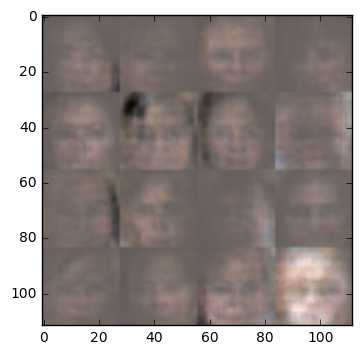

Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 0.5791
Epoch 1/1... Discriminator Loss: 0.8391... Generator Loss: 1.3585
Epoch 1/1... Discriminator Loss: 1.1014... Generator Loss: 0.5795
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 1.0737
Epoch 1/1... Discriminator Loss: 1.6263... Generator Loss: 0.3206
Epoch 1/1... Discriminator Loss: 0.8381... Generator Loss: 1.0007
Epoch 1/1... Discriminator Loss: 1.9679... Generator Loss: 3.6714
Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 0.8424
Epoch 1/1... Discriminator Loss: 0.9598... Generator Loss: 0.9635
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.2844
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 1.7419
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 1.9478
Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 0.4877
Epoch 1/1... Discriminator Loss: 0.9962... Generator Loss: 1.6738


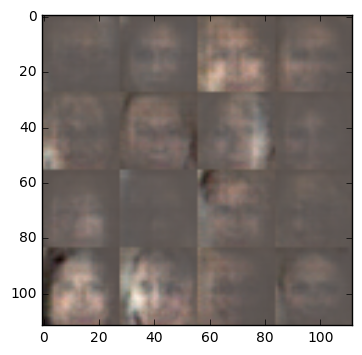

Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 0.4657
Epoch 1/1... Discriminator Loss: 0.8123... Generator Loss: 1.0223
Epoch 1/1... Discriminator Loss: 0.8990... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 0.9910... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.0116... Generator Loss: 0.5345
Epoch 1/1... Discriminator Loss: 0.9001... Generator Loss: 0.9007
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 0.9897
Epoch 1/1... Discriminator Loss: 0.7949... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 0.9747... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 0.9760... Generator Loss: 1.3470
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 0.9302... Generator Loss: 1.3949
Epoch 1/1... Discriminator Loss: 0.8787... Generator Loss: 0.9354
Epoch 1/1... Discriminator Loss: 0.9125... Generator Loss: 1.4521
Epoch 1/1... Discriminator Loss: 0.9004... Generator Loss: 0.7174


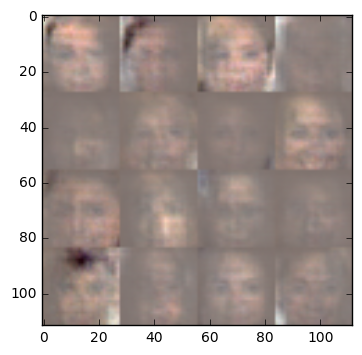

Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.4387
Epoch 1/1... Discriminator Loss: 0.7697... Generator Loss: 1.0683
Epoch 1/1... Discriminator Loss: 0.9114... Generator Loss: 1.2026
Epoch 1/1... Discriminator Loss: 0.9291... Generator Loss: 1.0313
Epoch 1/1... Discriminator Loss: 1.6313... Generator Loss: 0.2356
Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 0.5775
Epoch 1/1... Discriminator Loss: 0.8155... Generator Loss: 1.3337
Epoch 1/1... Discriminator Loss: 0.8123... Generator Loss: 1.2496
Epoch 1/1... Discriminator Loss: 1.1062... Generator Loss: 0.4501
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.4420
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.3221
Epoch 1/1... Discriminator Loss: 1.6385... Generator Loss: 0.2071
Epoch 1/1... Discriminator Loss: 0.9087... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 0.9332... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 0.7381... Generator Loss: 1.3969


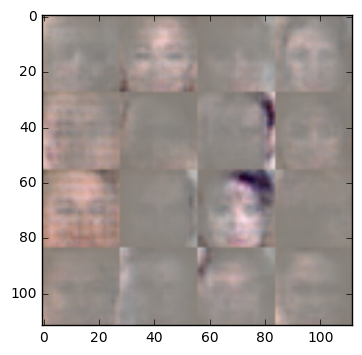

Epoch 1/1... Discriminator Loss: 0.8168... Generator Loss: 1.0497
Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 0.9004... Generator Loss: 0.9537
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.4027
Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 0.4857
Epoch 1/1... Discriminator Loss: 0.8544... Generator Loss: 1.7090
Epoch 1/1... Discriminator Loss: 0.8631... Generator Loss: 1.3043
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 1.1409
Epoch 1/1... Discriminator Loss: 0.8857... Generator Loss: 1.5480
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 0.4921
Epoch 1/1... Discriminator Loss: 0.8304... Generator Loss: 1.0798
Epoch 1/1... Discriminator Loss: 1.1578... Generator Loss: 0.4780
Epoch 1/1... Discriminator Loss: 0.9350... Generator Loss: 2.0504
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 0.5245
Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 0.3479


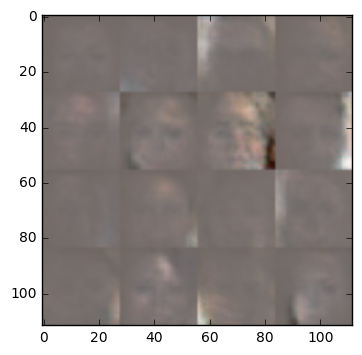

Epoch 1/1... Discriminator Loss: 1.0330... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 0.8835... Generator Loss: 1.1920
Epoch 1/1... Discriminator Loss: 0.9104... Generator Loss: 1.7644
Epoch 1/1... Discriminator Loss: 0.8778... Generator Loss: 1.1670
Epoch 1/1... Discriminator Loss: 1.1373... Generator Loss: 0.4389
Epoch 1/1... Discriminator Loss: 0.9955... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 0.9189... Generator Loss: 1.4705
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.0175... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 0.9145... Generator Loss: 1.0040
Epoch 1/1... Discriminator Loss: 0.9370... Generator Loss: 1.6554
Epoch 1/1... Discriminator Loss: 1.0378... Generator Loss: 0.5468
Epoch 1/1... Discriminator Loss: 0.9357... Generator Loss: 1.9309
Epoch 1/1... Discriminator Loss: 0.9600... Generator Loss: 0.6493


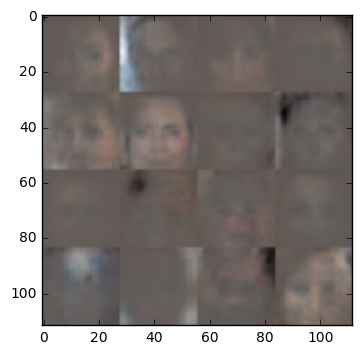

Epoch 1/1... Discriminator Loss: 0.9035... Generator Loss: 1.6764
Epoch 1/1... Discriminator Loss: 0.9482... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 0.8197... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 0.9505... Generator Loss: 2.0184
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.3494
Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 1.3794
Epoch 1/1... Discriminator Loss: 1.5384... Generator Loss: 0.2869
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 0.5856
Epoch 1/1... Discriminator Loss: 1.0120... Generator Loss: 1.6299
Epoch 1/1... Discriminator Loss: 0.8305... Generator Loss: 1.1162
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 0.5394
Epoch 1/1... Discriminator Loss: 1.6506... Generator Loss: 0.2717
Epoch 1/1... Discriminator Loss: 0.9499... Generator Loss: 0.9180


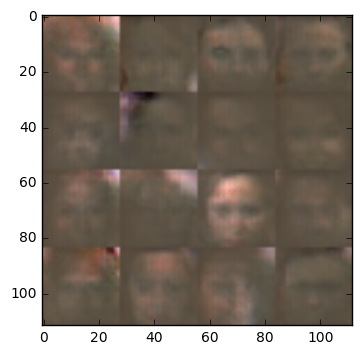

Epoch 1/1... Discriminator Loss: 0.8226... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 0.8593... Generator Loss: 1.3141
Epoch 1/1... Discriminator Loss: 1.1994... Generator Loss: 0.4967
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 0.3690
Epoch 1/1... Discriminator Loss: 0.9486... Generator Loss: 0.9806
Epoch 1/1... Discriminator Loss: 0.8946... Generator Loss: 1.0157
Epoch 1/1... Discriminator Loss: 0.8724... Generator Loss: 1.0768
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.3469
Epoch 1/1... Discriminator Loss: 1.0142... Generator Loss: 1.9281
Epoch 1/1... Discriminator Loss: 1.0167... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 0.5665
Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 0.6184
Epoch 1/1... Discriminator Loss: 0.8760... Generator Loss: 1.4091
Epoch 1/1... Discriminator Loss: 0.9608... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.0041... Generator Loss: 0.6672


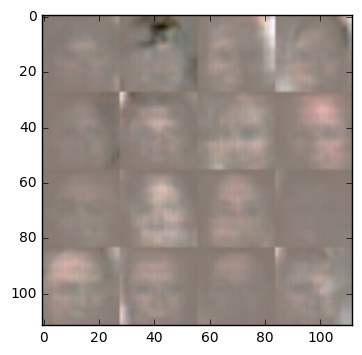

Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 0.5261
Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 0.5199
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 1.4522
Epoch 1/1... Discriminator Loss: 0.9957... Generator Loss: 1.3150
Epoch 1/1... Discriminator Loss: 0.9156... Generator Loss: 1.7068
Epoch 1/1... Discriminator Loss: 0.8303... Generator Loss: 1.4184
Epoch 1/1... Discriminator Loss: 0.8286... Generator Loss: 1.4493
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.4036
Epoch 1/1... Discriminator Loss: 0.8655... Generator Loss: 0.9709
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.4180
Epoch 1/1... Discriminator Loss: 1.0476... Generator Loss: 0.8503
Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 0.5078
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 2.0640
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.3547
Epoch 1/1... Discriminator Loss: 0.8703... Generator Loss: 1.5519


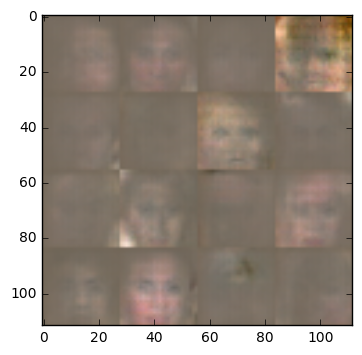

Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 1.4182
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.4442
Epoch 1/1... Discriminator Loss: 0.9093... Generator Loss: 1.0470
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 0.6111
Epoch 1/1... Discriminator Loss: 0.9171... Generator Loss: 1.0615
Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.0079... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 0.9618... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 0.6044
Epoch 1/1... Discriminator Loss: 0.8044... Generator Loss: 1.3441
Epoch 1/1... Discriminator Loss: 0.9923... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 0.9125... Generator Loss: 1.2171
Epoch 1/1... Discriminator Loss: 0.9775... Generator Loss: 0.9057


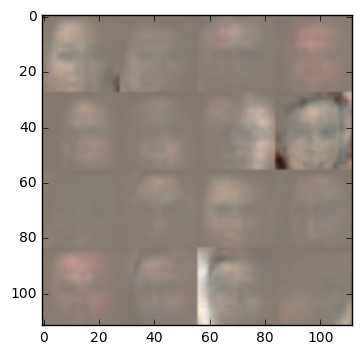

Epoch 1/1... Discriminator Loss: 0.8851... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 1.6468
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 1.7016
Epoch 1/1... Discriminator Loss: 1.5153... Generator Loss: 0.2423
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 0.5322
Epoch 1/1... Discriminator Loss: 0.9444... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 0.3875
Epoch 1/1... Discriminator Loss: 0.9179... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 0.8356... Generator Loss: 0.8969
Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 0.9013
Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 0.4914
Epoch 1/1... Discriminator Loss: 0.9589... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 1.1357
Epoch 1/1... Discriminator Loss: 1.0134... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 0.9263... Generator Loss: 1.3715


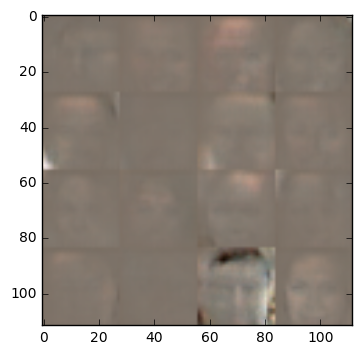

Epoch 1/1... Discriminator Loss: 0.9551... Generator Loss: 1.8783
Epoch 1/1... Discriminator Loss: 1.0588... Generator Loss: 1.7117
Epoch 1/1... Discriminator Loss: 0.9504... Generator Loss: 1.2072
Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 1.5940
Epoch 1/1... Discriminator Loss: 0.8760... Generator Loss: 1.2129
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 0.9676
Epoch 1/1... Discriminator Loss: 0.9411... Generator Loss: 1.5181
Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 1.3410
Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 0.9189... Generator Loss: 0.8972
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 2.7142
Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 0.8651
Epoch 1/1... Discriminator Loss: 0.9824... Generator Loss: 1.3991
Epoch 1/1... Discriminator Loss: 0.8749... Generator Loss: 0.9356
Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 0.6804


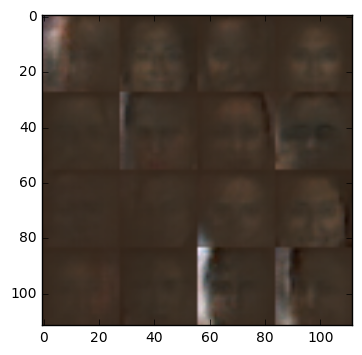

Epoch 1/1... Discriminator Loss: 0.9390... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 0.7969... Generator Loss: 1.0674
Epoch 1/1... Discriminator Loss: 1.0011... Generator Loss: 1.3359
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 1.0030
Epoch 1/1... Discriminator Loss: 0.8904... Generator Loss: 0.8573
Epoch 1/1... Discriminator Loss: 0.9307... Generator Loss: 1.1668
Epoch 1/1... Discriminator Loss: 0.9465... Generator Loss: 1.3456
Epoch 1/1... Discriminator Loss: 1.0368... Generator Loss: 1.3695
Epoch 1/1... Discriminator Loss: 0.8232... Generator Loss: 1.2245
Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.3124
Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 0.5843
Epoch 1/1... Discriminator Loss: 1.1649... Generator Loss: 0.5496
Epoch 1/1... Discriminator Loss: 0.8770... Generator Loss: 1.0998
Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 1.1819
Epoch 1/1... Discriminator Loss: 0.9787... Generator Loss: 0.7534


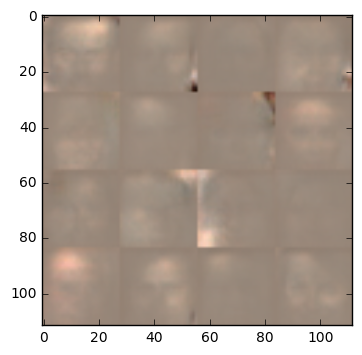

Epoch 1/1... Discriminator Loss: 0.8961... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 0.9584... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 0.8418... Generator Loss: 1.4381
Epoch 1/1... Discriminator Loss: 1.5021... Generator Loss: 0.2496
Epoch 1/1... Discriminator Loss: 0.8872... Generator Loss: 1.2148
Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 0.5266
Epoch 1/1... Discriminator Loss: 0.8809... Generator Loss: 1.4461
Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 0.8675... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 1.5136... Generator Loss: 0.3340
Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 1.4213
Epoch 1/1... Discriminator Loss: 0.9623... Generator Loss: 0.8722
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 0.9205... Generator Loss: 1.0115
Epoch 1/1... Discriminator Loss: 0.9640... Generator Loss: 0.8012


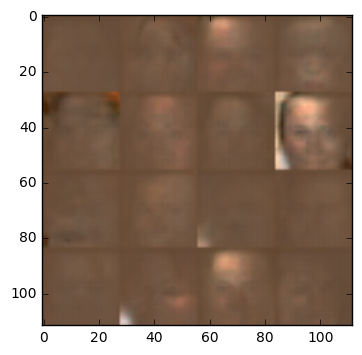

Epoch 1/1... Discriminator Loss: 0.8314... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 0.5312
Epoch 1/1... Discriminator Loss: 0.9347... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 0.9198... Generator Loss: 1.1816
Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 1.3616
Epoch 1/1... Discriminator Loss: 0.9568... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 0.9577
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 1.9917
Epoch 1/1... Discriminator Loss: 1.0030... Generator Loss: 1.0304
Epoch 1/1... Discriminator Loss: 0.8058... Generator Loss: 0.8515
Epoch 1/1... Discriminator Loss: 0.9615... Generator Loss: 1.3290
Epoch 1/1... Discriminator Loss: 1.1062... Generator Loss: 0.5427
Epoch 1/1... Discriminator Loss: 0.9715... Generator Loss: 1.3585
Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 1.4088


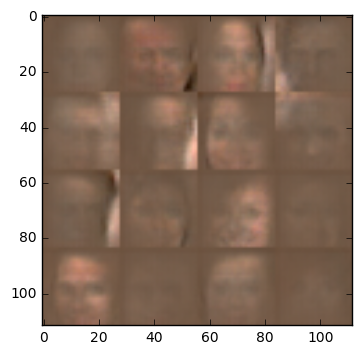

Epoch 1/1... Discriminator Loss: 0.8932... Generator Loss: 0.9842
Epoch 1/1... Discriminator Loss: 1.6010... Generator Loss: 0.2568
Epoch 1/1... Discriminator Loss: 0.9334... Generator Loss: 1.3583
Epoch 1/1... Discriminator Loss: 0.9698... Generator Loss: 0.9908
Epoch 1/1... Discriminator Loss: 1.0197... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.3946
Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 0.9160... Generator Loss: 1.3630
Epoch 1/1... Discriminator Loss: 0.9792... Generator Loss: 1.8571
Epoch 1/1... Discriminator Loss: 1.0793... Generator Loss: 0.5764
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.4296
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.3689
Epoch 1/1... Discriminator Loss: 0.9046... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.0113... Generator Loss: 0.9582
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.4004


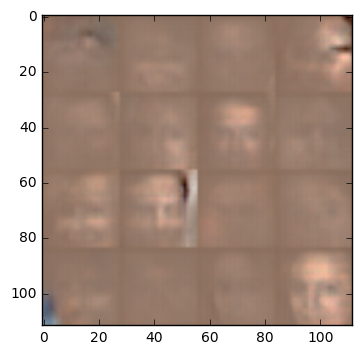

Epoch 1/1... Discriminator Loss: 1.0343... Generator Loss: 1.2877
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 1.7749... Generator Loss: 0.2023
Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 0.9333... Generator Loss: 0.9318
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 0.5904
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 1.0211
Epoch 1/1... Discriminator Loss: 1.0363... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 0.9091... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 0.9055... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 1.0105... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 0.5881


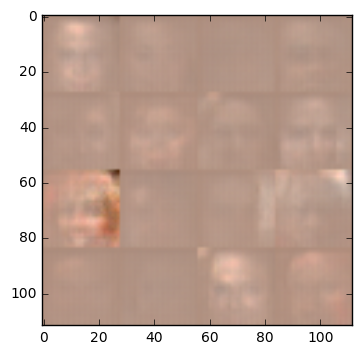

Epoch 1/1... Discriminator Loss: 1.0114... Generator Loss: 0.8900
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.4279
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.4274
Epoch 1/1... Discriminator Loss: 0.8718... Generator Loss: 0.8993
Epoch 1/1... Discriminator Loss: 0.8757... Generator Loss: 1.0348
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 2.2055
Epoch 1/1... Discriminator Loss: 0.8850... Generator Loss: 1.0512
Epoch 1/1... Discriminator Loss: 0.9580... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 0.9888... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.0098... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.0040... Generator Loss: 1.1515
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 0.3559
Epoch 1/1... Discriminator Loss: 0.9236... Generator Loss: 1.0901
Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 1.0842


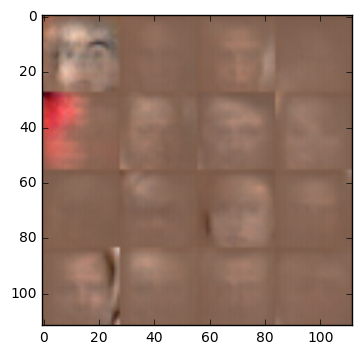

Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.5339
Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 1.4178
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 0.5344
Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 1.0458
Epoch 1/1... Discriminator Loss: 1.0266... Generator Loss: 0.9153
Epoch 1/1... Discriminator Loss: 1.0462... Generator Loss: 0.8958
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.3485
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.3858
Epoch 1/1... Discriminator Loss: 1.0239... Generator Loss: 0.9864
Epoch 1/1... Discriminator Loss: 1.0042... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 0.5015
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.4484
Epoch 1/1... Discriminator Loss: 1.6816... Generator Loss: 0.2281


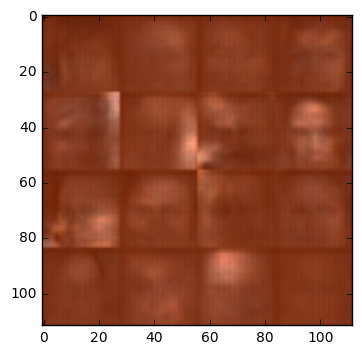

Epoch 1/1... Discriminator Loss: 0.9631... Generator Loss: 1.0837
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.4563
Epoch 1/1... Discriminator Loss: 0.9098... Generator Loss: 1.0918
Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 1.3768
Epoch 1/1... Discriminator Loss: 1.0649... Generator Loss: 0.9954
Epoch 1/1... Discriminator Loss: 1.0152... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 0.9497... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 0.9905... Generator Loss: 0.6103
Epoch 1/1... Discriminator Loss: 0.8677... Generator Loss: 0.9219
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.3420
Epoch 1/1... Discriminator Loss: 1.1316... Generator Loss: 0.5005
Epoch 1/1... Discriminator Loss: 1.0663... Generator Loss: 1.7626
Epoch 1/1... Discriminator Loss: 1.0484... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.0439... Generator Loss: 1.1058


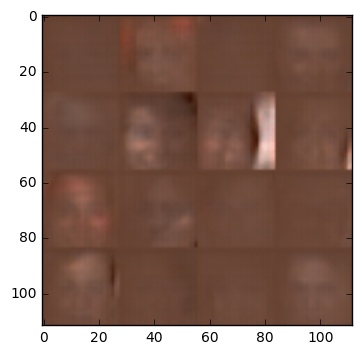

Epoch 1/1... Discriminator Loss: 1.0294... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.3508
Epoch 1/1... Discriminator Loss: 0.8808... Generator Loss: 0.8624
Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.4036
Epoch 1/1... Discriminator Loss: 0.9445... Generator Loss: 0.9929
Epoch 1/1... Discriminator Loss: 1.0057... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 0.9175... Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 0.9669... Generator Loss: 1.2708
Epoch 1/1... Discriminator Loss: 0.9805... Generator Loss: 0.9711
Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 1.9017
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.4481
Epoch 1/1... Discriminator Loss: 0.9476... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.4312
Epoch 1/1... Discriminator Loss: 0.8817... Generator Loss: 1.2413


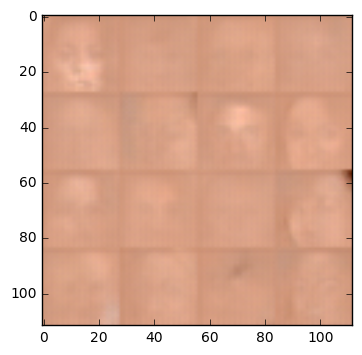

IndexError: list index out of range

In [77]:
batch_size = 50
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.